In [6]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import norm, laplace
from scripts.utils.missing_teeth_detector import MissingTeethRemover

In [2]:
ids = np.load("../data/split/ids_test.npy")

# What is the identification accuracy of the candidate labels following ablation when solely considering present instances?

In [102]:
def compute_accuracy(ids, n_samples=10, jaw="lower"):
    y_acc = []
    y_pred_acc = []
    missing_teeth_remover = MissingTeethRemover()
    for id in ids:
        for sample in np.arange(n_samples):
            y = np.load(f"../data/final/{id}/labels_{jaw}_{sample}.npy")
            y_pred = np.arange(0, 17)
            centroids = np.load(f"../data/final/{id}/centroids_{jaw}_{sample}.npy")
            y = missing_teeth_remover(centroids, y)
            y_pred = missing_teeth_remover(centroids, y_pred)
            y_acc.extend(y)
            y_pred_acc.extend(y_pred)
    y_acc = np.array(y_acc).reshape(-1)
    y_pred_acc = np.array(y_pred_acc).reshape(-1)
    return np.sum(y_acc == y_pred_acc) / len(y_acc)


print(f"Lower jaw: Accuracy {compute_accuracy(ids, 10, 'lower')}")
print(f"Upper jaw: Accuracy {compute_accuracy(ids, 10, 'upper')}")

Lower jaw: Accuracy 0.8882261622681592
Upper jaw: Accuracy 0.8873911587407903


# What is the accuracy of the labels following alignment when solely considering present instances?

In [104]:
def compute_accuracy(ids, n_samples=10, jaw="lower"):
    y_acc = []
    y_pred_acc = []
    missing_teeth_remover = MissingTeethRemover()
    for id in ids:
        for sample in np.arange(n_samples):
            y = np.load(f"../output/aligner/{id}/labels_{jaw}_{sample}.npy")
            y_pred = np.load(f"../output/aligner/{id}/labels_pred_{jaw}_{sample}.npy")
            centroids = np.load(f"../data/final/{id}/centroids_{jaw}_{sample}.npy")
            y = missing_teeth_remover(centroids, y)
            y_pred = missing_teeth_remover(centroids, y_pred)
            y_acc.extend(y)
            y_pred_acc.extend(y_pred)
    y_acc = np.array(y_acc).reshape(-1)
    y_pred_acc = np.array(y_pred_acc).reshape(-1)
    return np.sum(y_acc == y_pred_acc) / len(y_acc)


print(f"Lower jaw: Accuracy {compute_accuracy(ids, 10, 'lower')}")
print(f"Upper jaw: Accuracy {compute_accuracy(ids, 10, 'upper')}")

Lower jaw: Accuracy 0.9920745158918213
Upper jaw: Accuracy 0.9911252511721367


# What is the identification accuracy of the U-net?

In [26]:
def compute_identification_accuracy(ids, max_distance=3, jaw="lower"):
    centroid_missing = np.array([0, 0, 0])
    identified_teeth = 0
    misidentified_teeth = 0
    for id in ids:
        centroids = np.load(f"../data/processed/{id}/centroids_{jaw}_true.npy")
        centroids_pred = np.load(f"../data/processed/{id}/centroids_pred_{jaw}.npy")
        for label, centroid in enumerate(centroids):
            dif = np.linalg.norm(centroids_pred - centroid, axis=1)
            label_pred = np.argmin(dif)
            dist, centroid_pred = dif[label_pred], centroids_pred[label_pred]
            # Missing tooth
            if np.array_equal(centroid, centroid_missing):
                # Do nothing
                pass
            # Close enough to the actual centroid, but not missing
            elif dist <= max_distance and not np.array_equal(centroid_pred, centroid_missing):
                centroids_pred[label_pred] = centroid_missing
                if label == label_pred:
                    identified_teeth += 1
                else:
                    misidentified_teeth += 1
            else:
                misidentified_teeth += 1
    # return misidentified_teeth + identified_teeth
    return identified_teeth / (identified_teeth + misidentified_teeth)


print(f"Lower jaw: Accuracy {compute_identification_accuracy(ids, 3, 'lower')}")
print(f"Upper jaw: Accuracy {compute_identification_accuracy(ids, 3, 'upper')}")

Lower jaw: Accuracy 0.9724349157733537
Upper jaw: Accuracy 0.9710031347962382


# What is the detection accuracy of the U-net?

In [128]:
def compute_detection_accuracy(ids, max_distance=3, jaw="lower"):
    centroid_missing = np.array([0, 0, 0])
    detected_teeth = 0
    missed_teeth = 0
    for id in ids:
        centroids = np.load(f"../data/processed/{id}/centroids_{jaw}_true.npy")
        centroids_pred = np.load(f"../data/processed/{id}/centroids_pred_{jaw}.npy")
        for label, centroid in enumerate(centroids):
            dif = np.linalg.norm(centroids_pred - centroid, axis=1)
            label_pred = np.argmin(dif)
            dist, centroid_pred = dif[label_pred], centroids_pred[label_pred]
            # Missing tooth
            if np.array_equal(centroid, centroid_missing):
                # Do nothing
                pass
            # Close enough to the actual centroid, but not missing
            elif dist <= max_distance and not np.array_equal(centroid_pred, centroid_missing):
                detected_teeth += 1
                centroids_pred[label_pred] = centroid_missing
            else:
                missed_teeth += 1
    return detected_teeth / (detected_teeth + missed_teeth)


print(f"Lower jaw: Accuracy {compute_detection_accuracy(ids, 3, 'lower')}")
print(f"Upper jaw: Accuracy {compute_detection_accuracy(ids, 3, 'upper')}")

Lower jaw: Accuracy 0.9892802450229708
Upper jaw: Accuracy 0.9905956112852664


# What were the cases where the network made mistakes?

In [135]:
missing_teeth_remover = MissingTeethRemover()


def find_mistakes(ids, n_samples=10, jaw="lower"):
    id_error_acc = []
    for id in ids:
        for sample in np.arange(n_samples):
            y = np.load(f"../output/aligner/{id}/labels_{jaw}_{sample}.npy")
            y_pred = np.load(f"../output/aligner/{id}/labels_pred_{jaw}_{sample}.npy")
            centroids = np.load(f"../data/final/{id}/centroids_{jaw}_{sample}.npy")
            y = missing_teeth_remover(centroids, y)
            y_pred = missing_teeth_remover(centroids, y_pred)
            if not np.array_equal(y, y_pred):
                id_error_acc.append((id, sample))
    return id_error_acc


sample_error_acc_lower = find_mistakes(ids, 10, jaw="lower")
sample_error_acc_upper = find_mistakes(ids, 10, jaw="upper")
np.save("../output/errors/sample_error_acc_lower.npy", sample_error_acc_lower)
np.save("../output/errors/sample_error_acc_upper.npy", sample_error_acc_upper)

# What was the identification accuracy of double teeth following ablation?

In [15]:
def compute_accuracy_double_teeth(ids, n_samples=10, jaw="lower", double_tooth_label=16):
    double_teeth_detected = 0
    double_teeth_missed = 0
    for id in ids:
        for sample in range(n_samples):
            y = np.load(f"../output/aligner/{id}/labels_{jaw}_{sample}.npy")
            y_pred = np.arange(0, 17)
            centroids = np.load(f"../data/final/{id}/centroids_{jaw}_{sample}.npy")
            i_double_tooth = np.where(y == double_tooth_label)[0][0]
            # Check if double tooth exists
            if not np.array_equal(centroids[i_double_tooth], np.array([0, 0, 0])):
                if y[i_double_tooth] == y_pred[i_double_tooth]:
                    double_teeth_detected += 1
                else:
                    double_teeth_missed += 1
    return double_teeth_missed + double_teeth_detected
    return double_teeth_detected / (double_teeth_detected + double_teeth_missed)

print(f"Lower jaw: Accuracy {compute_accuracy_double_teeth(ids, 10, 'lower', double_tooth_label=16)}")
print(f"Upper jaw: Accuracy {compute_accuracy_double_teeth(ids, 10, 'upper', double_tooth_label=16)}")

Lower jaw: Accuracy 503
Upper jaw: Accuracy 485


# What was the identification accuracy of double teeth for DentAssignNet?

In [16]:
def compute_accuracy_double_teeth(ids, n_samples=10, jaw="lower", double_tooth_label=16):
    double_teeth_detected = 0
    double_teeth_missed = 0
    for id in ids:
        for sample in range(n_samples):
            y = np.load(f"../output/aligner/{id}/labels_{jaw}_{sample}.npy")
            y_pred = np.load(f"../output/aligner/{id}/labels_pred_{jaw}_{sample}.npy")
            centroids = np.load(f"../data/final/{id}/centroids_{jaw}_{sample}.npy")
            i_double_tooth = np.where(y == double_tooth_label)[0][0]
            # Check if double tooth exists
            if not np.array_equal(centroids[i_double_tooth], np.array([0, 0, 0])):
                if y[i_double_tooth] == y_pred[i_double_tooth]:
                    double_teeth_detected += 1
                else:
                    double_teeth_missed += 1
    return double_teeth_missed + double_teeth_detected
    return double_teeth_detected / (double_teeth_detected + double_teeth_missed)

print(f"Lower jaw: Accuracy {compute_accuracy_double_teeth(ids, 10, 'lower', double_tooth_label=16)}")
print(f"Upper jaw: Accuracy {compute_accuracy_double_teeth(ids, 10, 'upper', double_tooth_label=16)}")

Lower jaw: Accuracy 503
Upper jaw: Accuracy 485


# What was the identification accuracy of swapped teeth for DentAssignNet?

In [20]:
missing_teeth_remover = MissingTeethRemover()

def compute_accuracy_swapped_teeth(ids, n_samples=10, jaw="lower"):
    y_acc = []
    y_pred_acc = []
    for id in ids:
        for sample in range(n_samples):
            y_default = np.arange(17)
            y = np.load(f"../output/aligner/{id}/labels_{jaw}_{sample}.npy")
            y_pred = np.load(f"../output/aligner/{id}/labels_pred_{jaw}_{sample}.npy")
            centroids = np.load(f"../data/final/{id}/centroids_{jaw}_{sample}.npy")
            y = missing_teeth_remover(centroids, y)
            y_pred = missing_teeth_remover(centroids, y_pred)
            y_default = missing_teeth_remover(centroids, y_default)
            # i_swapped = y != y_default
            # y = y[i_swapped]
            # y_pred = y_pred[i_swapped]
            y_acc.extend(y.tolist())
            y_pred_acc.extend(y_pred.tolist())
    y_acc = np.array(y_acc)
    y_pred_acc = np.array(y_pred_acc)
    return len(y_acc)
    # return np.sum(y_acc != y_pred_acc)
    return np.sum(y_acc == y_pred_acc) / len(y_acc)

print(f"Lower jaw: Accuracy {compute_accuracy_swapped_teeth(ids, 10, 'lower')}")
print(f"Upper jaw: Accuracy {compute_accuracy_swapped_teeth(ids, 10, 'upper')}")

Lower jaw: Accuracy 12239
Upper jaw: Accuracy 11944


# What samples were correctly labelled and had two swaps and at least a few missing teeth?

In [36]:
from scripts.utils.missing_teeth_detector import MissingTeethDetector

missing_teeth_remover = MissingTeethRemover()
missing_teeth_detector = MissingTeethDetector()

def find_correct(ids, n_samples=10, jaw="lower"):
    id_success_acc = []
    for id in ids:
        for sample in range(n_samples):
            y_default = np.arange(17)
            y = np.load(f"../output/aligner/{id}/labels_{jaw}_{sample}.npy")
            y_pred = np.load(f"../output/aligner/{id}/labels_pred_{jaw}_{sample}.npy")
            centroids_default = np.load(f"../data/processed/{id}/centroids_{jaw}.npy")
            centroids = np.load(f"../data/final/{id}/centroids_{jaw}_{sample}.npy")
            no_removal = np.array_equal(centroids_default[y_default], centroids[y])
            y = missing_teeth_remover(centroids, y)
            y_pred = missing_teeth_remover(centroids, y_pred)
            y_default = missing_teeth_remover(centroids, y_default)
            i_swapped = y != y_default
            y = y[i_swapped]
            y_pred = y_pred[i_swapped]
            if (len(y) >= 3) and sum(y == y_pred) == len(y) and no_removal \
                    and len(missing_teeth_detector(centroids, np.arange(17))) > 3:
                id_success_acc.append((id, sample))
    return id_success_acc


sample_correct_acc_lower = find_correct(ids, 10, jaw="lower")
sample_correct_acc_upper = find_correct(ids, 10, jaw="upper")
np.save("../output/correct/sample_correct_acc_lower.npy", sample_correct_acc_lower)
np.save("../output/correct/sample_correct_acc_upper.npy", sample_correct_acc_upper)

In [37]:
len(sample_correct_acc_upper)

41

# Can you visualize activation before assignment?

In [54]:
import random
i_row_shuffle = np.arange(17)
random.shuffle(i_row_shuffle)
print(i_row_shuffle)

[14  0  6  5  8  1  2  7  3 15  4 12 11 13 16 10  9]


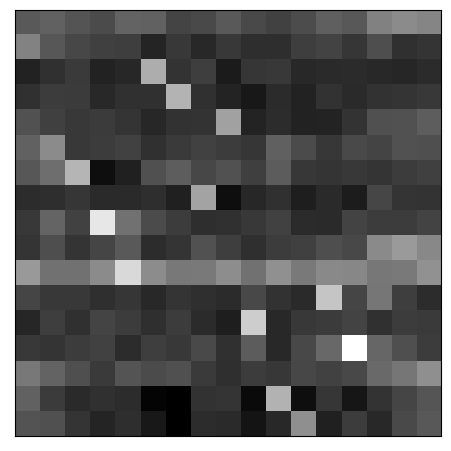

In [55]:
import matplotlib.pyplot as plt

# id = "HDVYC7UQ"
id = "01MAVT6A"
i_row_shuffle = [14, 0, 6,  5,  8,  1,  2,  7,  3, 15,  4, 12, 11, 13, 16, 10, 9]
jaw = "upper"
sample = "9"
fig, ax = plt.subplots(nrows=1, ncols=1)
labels = np.load(f"../data/final/{id}/labels_{jaw}_9.npy")
centroids = np.load(f"../data/final/{id}/centroids_{jaw}_9.npy")
activation = np.load(f"../output/aligner/{id}/labels_pred_activation_{jaw}_{sample}.npy")
# activation[np.arange(17), np.arange(17)] -= 6
activation[activation >= 5] -= 5
activation += np.random.randn(17, 17)
im = ax.imshow(activation[i_row_shuffle], cmap="gray")
fig.tight_layout()
ax.set_xticks([])
ax.set_yticks([])
plt.show()
fig.savefig("activation.png")
plt.show()

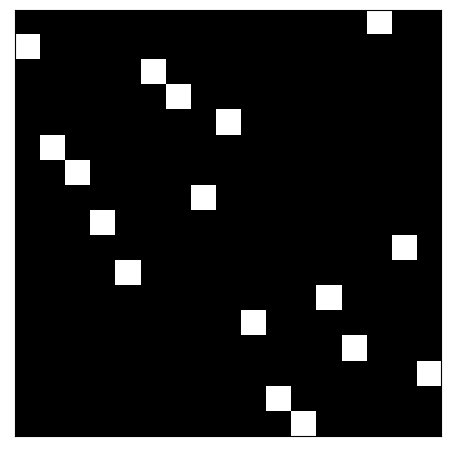

In [56]:
import matplotlib.pyplot as plt

id = "01MAVT6A"
i_row_shuffle = [14, 0, 6,  5,  8,  1,  2,  7,  3, 15,  4, 12, 11, 13, 16, 10, 9]
jaw = "upper"
sample = "9"
fig, ax = plt.subplots(nrows=1, ncols=1)
labels = np.load(f"../data/final/{id}/labels_{jaw}_9.npy")
centroids = np.load(f"../data/final/{id}/centroids_{jaw}_9.npy")
activation = np.load(f"../output/aligner/{id}/labels_pred_2d_{jaw}_{sample}.npy")
im = ax.imshow(activation[i_row_shuffle], cmap="gray")
fig.tight_layout()
ax.set_xticks([])
ax.set_yticks([])
plt.show()
fig.savefig("assignment.png")
plt.show()

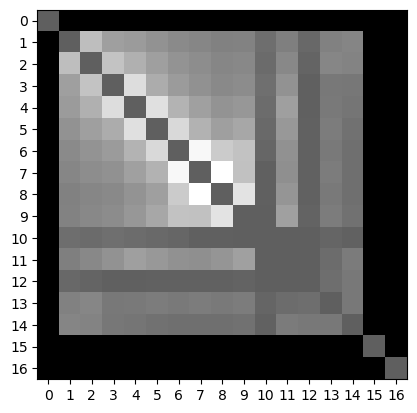

Labels [ 0  1  2  3  4  5  6  7  8  9 12 11 10 14 13 15 16]
Centroids [[  0.           0.           0.        ]
 [ 22.68617583  20.03660513 -91.23973258]
 [ 20.82440465  11.56809712 -90.83730874]
 [ 18.26734695   3.03618889 -90.49213809]
 [ 16.82415056  -3.6434789  -89.1930132 ]
 [ 13.90394477  -9.68509171 -87.51400151]
 [  9.51549301 -12.95462001 -86.52403513]
 [  5.05051869 -14.86396604 -85.98840107]
 [  0.53337333 -14.84692017 -85.81705716]
 [ -4.3886285  -13.68914135 -85.63653909]
 [-13.86045302   2.070705   -90.27754864]
 [-11.6600719   -4.06735856 -88.13857631]
 [ -8.59153482 -10.07360199 -86.51360547]
 [-20.70284103  18.30001844 -88.65626644]
 [-17.76740178   9.58510674 -89.66569819]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]


In [491]:
import matplotlib.pyplot as plt

id = "0TMOBYXS"
labels = np.load(f"../data/final/{id}/labels_lower_0.npy")
centroids = np.load(f"../data/final/{id}/centroids_lower_0.npy")
score_map = np.load(f"../data/final/{id}/score_map_lower_0.npy")
plt.imshow(score_map, cmap="gray")
plt.xticks(np.arange(17))
plt.yticks(np.arange(17))
plt.show()
print(f"Labels {labels}")
print(f"Centroids {centroids}")

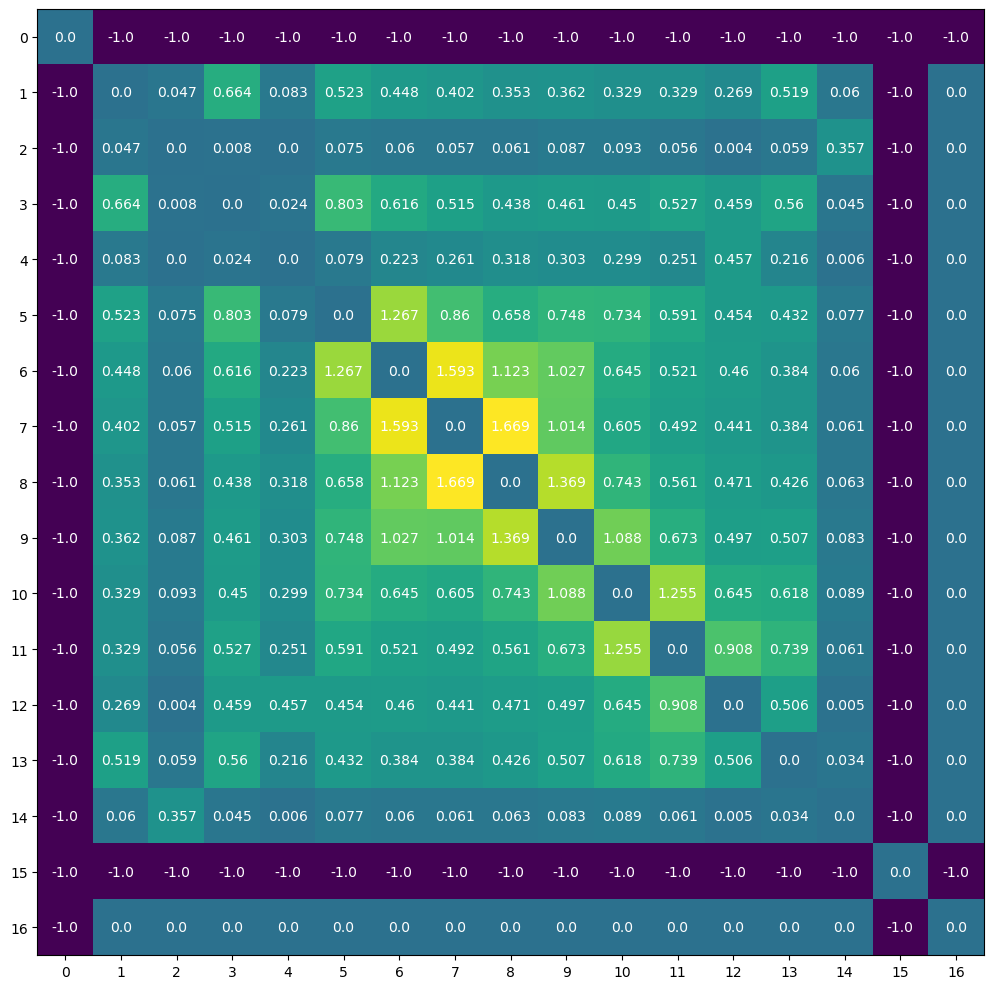

Labels [ 0  1  4  3  2  5  6  7  8  9 10 11 12 13 16 15 14]
Centroids [[  0.           0.           0.        ]
 [ 22.68617583  20.03660513 -91.23973258]
 [ 16.82415056  -3.6434789  -89.1930132 ]
 [ 18.26734695   3.03618889 -90.49213809]
 [ 20.82440465  11.56809712 -90.83730874]
 [ 13.90394477  -9.68509171 -87.51400151]
 [  9.51549301 -12.95462001 -86.52403513]
 [  5.05051869 -14.86396604 -85.98840107]
 [  0.53337333 -14.84692017 -85.81705716]
 [ -4.3886285  -13.68914135 -85.63653909]
 [ -8.59153482 -10.07360199 -86.51360547]
 [-11.6600719   -4.06735856 -88.13857631]
 [-13.86045302   2.070705   -90.27754864]
 [-17.76740178   9.58510674 -89.66569819]
 [ 19.08227636 -16.52791695 -87.86669983]
 [  0.           0.           0.        ]
 [-20.70284103  18.30001844 -88.65626644]]


In [152]:
import matplotlib.pyplot as plt

id = "0TMOBYXS"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
labels = np.load(f"../data/final/{id}/labels_lower_0.npy")
centroids = np.load(f"../data/final/{id}/centroids_lower_0.npy")
score_map = np.load(f"../data/final/{id}/score_map_lower_0.npy")
for i in range(17):
    for j in range(17):
        text = ax.text(j, i, round(score_map[i, j][0], 3),
                       ha="center", va="center", color="w")
im = ax.imshow(score_map)
fig.tight_layout()
ax.set_xticks(np.arange(17))
ax.set_yticks(np.arange(17))
plt.show()
fig.savefig("test.png")
print(f"Labels {labels}")
print(f"Centroids {centroids}")

# Are the predicted labels actually predicted?

In [2]:
import json
import trimesh


def compute_random_color():
    """
    Returns:
        r, g, b code
    """
    r, g, b = np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)
    return r, g, b


random_colors = [compute_random_color() for _ in range(100)]
id = "0OTKQ5J9"
jaw = "lower"
mesh = trimesh.load(f"../data/raw/patient_obj/{id}/{id}_{jaw}.obj", process=False)
with open(f"../data/raw/predicted_patient_labels_2/{id}_{jaw}.json", "r") as f:
    labels_pred = json.load(f)
    # Convert the labels to numpy arrays.
    tooth_labels_pred = np.array(labels_pred["labels"])
with open(f"../data/raw/patient_labels/{id}/{id}_{jaw}.json", "r") as f:
    labels = json.load(f)
    # Convert the labels to numpy arrays.
    instance_labels = np.array(labels["instances"])
    tooth_labels = np.array(labels["labels"])
mesh.visual.vertex_colors = [random_colors[label] for label in tooth_labels]
mesh.export("mesh.obj")
mesh.visual.vertex_colors = [random_colors[label] for label in tooth_labels_pred]
mesh.export("mesh_pred.obj")
print("Done.")

Done.
